<a href="https://www.kaggle.com/code/fahmirk/web-scraping-e-ipo-data-with-selenium?scriptVersionId=208719442" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


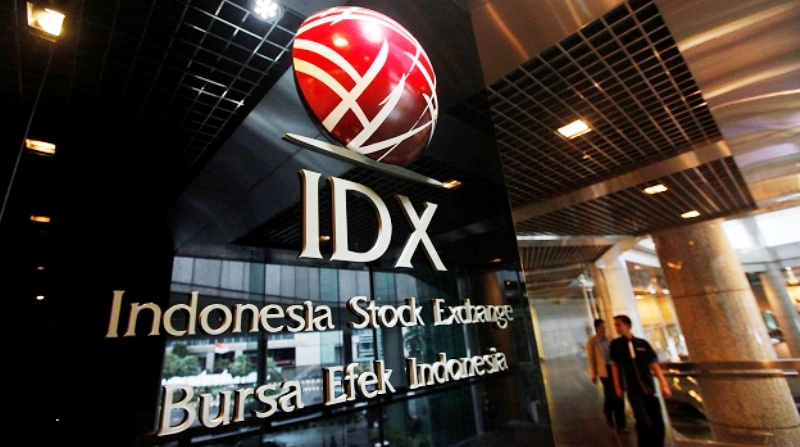<br>
<cite>Image from [m.cobisnis.com](https://m.cobisnis.com/tahun-2023-bei-targetkan-ipo-57-perusahaan)<cite>

**This notebook will explain how Chrome Driver and Selenium in Python can scrape data available on the e-IPO (Electronic Indonesia Public Offering) website in Realtime.**

### First, please **Upvote** this notebook if u like it :)

The notebook can be used to scrape all the company data available on the e-IPO website in real time, as long as the structure of the website is not changed (only the data of the company that is going to IPO is added).

**Notes**: If there is a change in the website structure, I may revise this notebook so that it can work properly

**Update**:<br>
**5 August 2023**: The first **3 days return data** has been included in the dataset.<br>
**15 August 2023**: Dataset of **Listing Boards (Papan Pencatatan)** at the time of IPO available for each company code.<br>
**25 October 2023**: Return from Listing Date Data has been included in the dataset.<br>
**8 January 2024**: Listing board data is no longer retrieved manually from google spreadsheets using gdown, but uses direct access to the IDX website via selenium with proxy and undetected chromedriver. The web scraping process has been displayed in the form of a progress bar using the tqdm package.<br>
**10 January 2024**: Return data extended to the first 7 days return from 3 days return.<br>
**28 January 2024**: In addition to being exported into CSV, the dataset is also stored in google spreadsheet.<br>
**20 February 2024**: Code is optimized. First, the existing company data in the dataset is not retrieved from the website, so the scraping process only retrieves new company data. Second, minimizing the use of syntax time.sleep in the code and replacing it with function presence of element by XPATH.<br>
**25 April 2024**: Adding Warrant Data.<br>
**20 May 2024**: Change the source on the listing board data from the Stock List page (https://www.idx.co.id/id/data-pasar/data-saham/daftar-saham) to the List Activity page (https://www.idx.co.id/id/perusahaan-tercatat/aktivitas-pencatatan) and retrieved manually.<br>
**30 October 2024**: Improve the quality and readability of the code by making the following changes:
- Added new documentation in some code for readers to understand.
- Some parts of the code are written in the form of functions, such as load_dataset(), bypass(), and scrape_data().
- Underwriter(s) column is improved by extracting the broker code only, not in the form of a list with the broker name in it.<br>

**17 November 2024**: yfinance was replaced with tvDataFeed due to incomplete data on yfinance for recent IPOs such as DAAZ.

# Prerequisite

In [1]:
# System Update and Library Installation
# Update package lists and install necessary libraries for Chrome and Selenium
!apt-get update -y && apt-get install -y \
    libglib2.0-0 \
    libnss3 \
    libdbus-glib-1-2 \
    libgconf-2-4 \
    libfontconfig1 \
    gconf2-common \
    libwayland-server0 \
    libgbm1 \
    udev \
    libu2f-udev \
    libjsoncpp25 \
    libxnvctrl0 && \
    apt --fix-broken install -y

# Install Google Chrome
!wget -nc -P /usr/lib https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb && \
    dpkg -i /usr/lib/google-chrome-stable_current_amd64.deb

# Check Chrome version
import subprocess
chrome_version = subprocess.check_output(
    ["dpkg-query", "--show", "--showformat='${Version}'", "google-chrome-stable"]
).decode("utf-8").strip("''").split("-")[0]

# Install ChromeDriver
!wget -nc -P /usr/lib "https://storage.googleapis.com/chrome-for-testing-public/121.0.6167.85/linux64/chromedriver-linux64.zip" && \
    mkdir -p /usr/lib/chrome-browser && \
    unzip -o /usr/lib/chromedriver-linux64.zip -d /usr/lib/chrome-browser/ && \
    apt --fix-broken install -y

# Install undetected ChromeDriver and other packages
!pip install undetected-chromedriver \
    selenium \
    selenium-wire \
    selenium_authenticated_proxy \
    selenium_stealth \
    gspread \
    gspread_dataframe \
    --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git && \
    pip install blinker==1.7.0 xlrd

Get:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Get:6 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [28.6 kB]
Get:7 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1582 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [30.9 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [4137 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]
Get:11 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3428 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1568 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-se

# Preparation

First, import all libraries used in this notebook

In [2]:
# Import all packages required
from seleniumwire import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ChromeOptions
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import InvalidSelectorException
from selenium.webdriver.common.keys import Keys
from selenium_stealth import stealth
from selenium_authenticated_proxy import SeleniumAuthenticatedProxy
from selenium.webdriver.support.ui import Select
import random
import undetected_chromedriver as uc
import re
import pandas as pd
from PIL import Image
import sys
import numpy as np
import time
from io import BytesIO
import datetime
import os
import requests
from tqdm.auto import tqdm
from kaggle_secrets import UserSecretsClient
from oauth2client.service_account import ServiceAccountCredentials
import json
import gspread
from gspread_dataframe import set_with_dataframe
from tvDatafeed import TvDatafeed, Interval
import xlrd

# Extend Python path to include ChromeDriver
sys.path.insert(0,'/usr/lib/chrome-browser/chromedriver')

# Pandas setting
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

Here I created some functions that are used in this notebook to make work easier. In the *update_database* function, I use *Try* and *Except* statements to handle errors that occur. If an error occurs, then no value is created in the data.

In [3]:
# Define Functions
def Status_IPO(datalist):
    """Determine the current IPO status based on the data list."""
    classification = ["Pre-Effective", "Book Building", "Offering", "Waiting For Offering", 
                      "Allotment", "Closed", "Canceled", "Postpone"][::-1]
    status = [item for item in classification if item in datalist]
    if len(set(status)) == 1:
        return status[0]
    else:
        status.remove("Book Building")
        return status[0]
    
def is_string_unique(string, lst):
    """Check if a string is unique in a list."""
    return lst.count(string) == 1

def convert_to_integer(df, columns):
    """Convert specified DataFrame columns to integers after cleaning."""
    for column in columns:
        df[column] = df[column].str.replace(',', '', regex=True).where(df[column].notnull(), np.nan)
        df[column] = df[column].str.replace('IDR ', '').astype('Int64').where(df[column].notnull(), np.nan)
    return df

def warrant_per_share_ratio(warrantdata):
    """Calculate the warrant per share ratio from the given data."""
    if warrantdata is None:
        return 0
    elif ':' in warrantdata:
        warrantdata = warrantdata.split(':')
        return (float(warrantdata[1]) / float(warrantdata[0]))
    else:
        return warrantdata
        
# Suppress FutureWarnings for cleaner output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Start Web Driver

After importing the libraries and declaring some functions, we can start extracting information from the e-IPO website. (https://www.e-ipo.co.id/en/ipo/index).<br>First, we need to create a connection with ChromeDriver

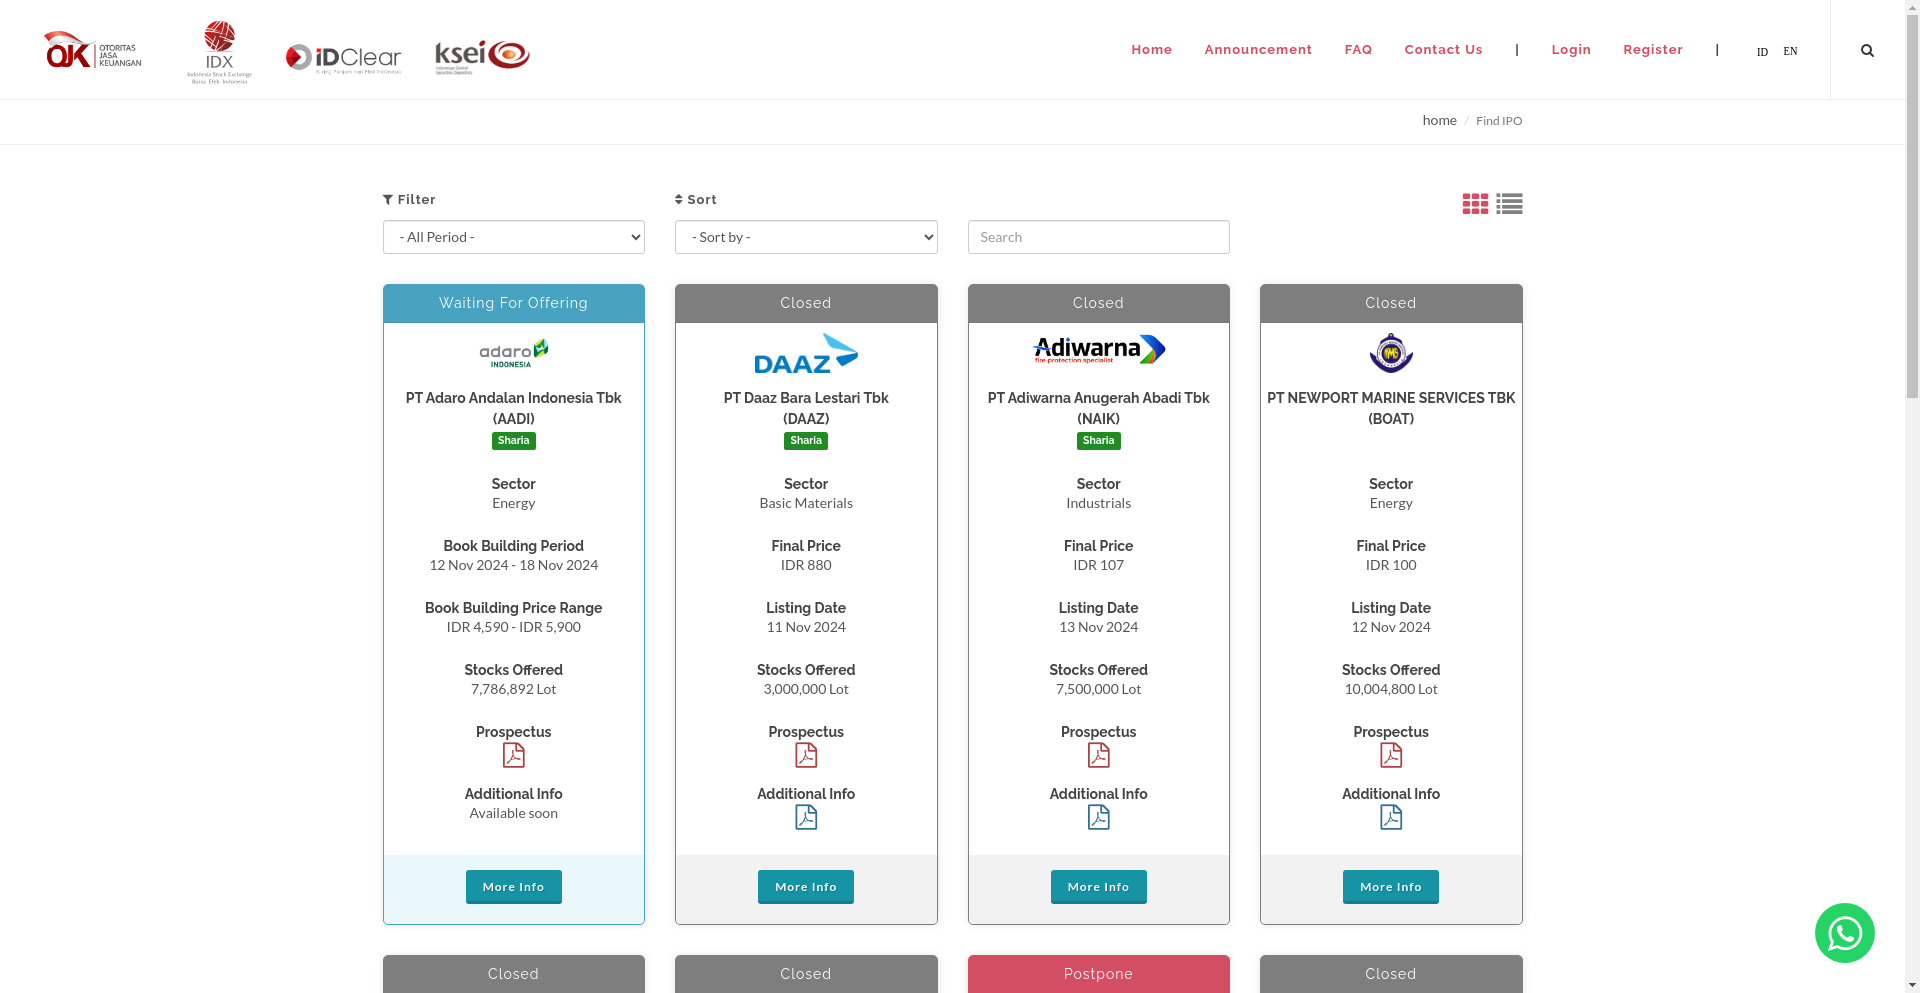

In [4]:
def initialize_driver(stealth_mode=False):
    """
    Initialize the Selenium Chrome web driver with specified options.

    Returns:
        uc.Chrome: An instance of the Chrome web driver.
    """
    options = uc.ChromeOptions()
    options.add_argument('--headless')  # Run in headless mode
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument('user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/90.0.4430.93 Safari/537.36')
    options.add_argument("--window-size=1920,1080")
    driver = uc.Chrome(options=options)
    
    if stealth_mode:
        # Stealth settings for evading detection
        stealth(driver,
                languages=["en-US", "en"],
                vendor="Google Inc.",
                platform="Win32",
                webgl_vendor="Intel Inc.",
                renderer="Intel Iris OpenGL Engine",
                fix_hairline=True,
                )

    return driver


driver = initialize_driver(stealth_mode=True)

# Navigate to the IPO website
url = "https://www.e-ipo.co.id/en/ipo/index"
driver.get(url)

# Timeout setting for waiting for elements
timeout = 10
time.sleep(3) # Allow time for the website to load

# Take a screenshot of the website
Image.open(BytesIO(driver.get_screenshot_as_png()))

In [5]:
def manualpass_cloudflare(driver):
    
    """
    Simulate mouse movement to bypass Cloudflare protection.
    
    Use this function if you encounter Cloudflare during the scraping process.
    It simulates a mouse movement and click to help bypass the security measures.
    """
    
    enable_cursor = """
            function enableCursor() {
              var seleniumFollowerImg = document.createElement("img");
              seleniumFollowerImg.setAttribute('src', 'data:image/png;base64,'
                + 'iVBORw0KGgoAAAANSUhEUgAAABQAAAAeCAQAAACGG/bgAAAAAmJLR0QA/4ePzL8AAAAJcEhZcwAA'
                + 'HsYAAB7GAZEt8iwAAAAHdElNRQfgAwgMIwdxU/i7AAABZklEQVQ4y43TsU4UURSH8W+XmYwkS2I0'
                + '9CRKpKGhsvIJjG9giQmliHFZlkUIGnEF7KTiCagpsYHWhoTQaiUUxLixYZb5KAAZZhbunu7O/PKf'
                + 'e+fcA+/pqwb4DuximEqXhT4iI8dMpBWEsWsuGYdpZFttiLSSgTvhZ1W/SvfO1CvYdV1kPghV68a3'
                + '0zzUWZH5pBqEui7dnqlFmLoq0gxC1XfGZdoLal2kea8ahLoqKXNAJQBT2yJzwUTVt0bS6ANqy1ga'
                + 'VCEq/oVTtjji4hQVhhnlYBH4WIJV9vlkXLm+10R8oJb79Jl1j9UdazJRGpkrmNkSF9SOz2T71s7M'
                + 'SIfD2lmmfjGSRz3hK8l4w1P+bah/HJLN0sys2JSMZQB+jKo6KSc8vLlLn5ikzF4268Wg2+pPOWW6'
                + 'ONcpr3PrXy9VfS473M/D7H+TLmrqsXtOGctvxvMv2oVNP+Av0uHbzbxyJaywyUjx8TlnPY2YxqkD'
                + 'dAAAAABJRU5ErkJggg==');
              seleniumFollowerImg.setAttribute('id', 'selenium_mouse_follower');
              seleniumFollowerImg.setAttribute('style', 'position: absolute; z-index: 99999999999; pointer-events: none; left:0; top:0');
              document.body.appendChild(seleniumFollowerImg);
              document.onmousemove = function (e) {
                document.getElementById("selenium_mouse_follower").style.left = e.pageX + 'px';
                document.getElementById("selenium_mouse_follower").style.top = e.pageY + 'px';
              };
            };

            enableCursor();
    """

    driver.execute_script(enable_cursor)
    action = webdriver.ActionChains(driver)
    action.move_by_offset(540, 300).perform() # Move the mouse to a specific location
    time.sleep(1)
    action.click().perform() # Click to bypass
    action.move_by_offset(-540, -300).perform() # Move the mouse to a specific location


def bypass(driver, max_bypass_attempt=24):
    """
    Repeatedly attempts to bypass Cloudflare protection on a website using the specified WebDriver.
    
    This function tries to access the protected webpage by simulating human interaction 
    to bypass Cloudflare's security. It attempts up to `max_bypass_attempt` times, 
    calling `manualpass_cloudflare()` in each loop iteration. If the desired element 
    becomes accessible, the loop breaks, indicating successful bypassing of protection.

    Args:
        driver (selenium.webdriver): The WebDriver instance used for navigating the site.
        max_bypass_attempt (int, optional): The maximum number of attempts to bypass 
            Cloudflare protection. Defaults to 24.

    Raises:
        selenium.common.exceptions.TimeoutException: If the bypass fails after the specified 
            number of attempts and the protected element is not found.
    """
    bypass_attempt = 0
    while bypass_attempt < max_bypass_attempt: 
        manualpass_cloudflare(driver)  # Handle Cloudflare protection          
        try:
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="w0"]/div[1] | //*[@id="wrapper"]/section[2]/div/div/div[2]')))
            break
        except:
            pass

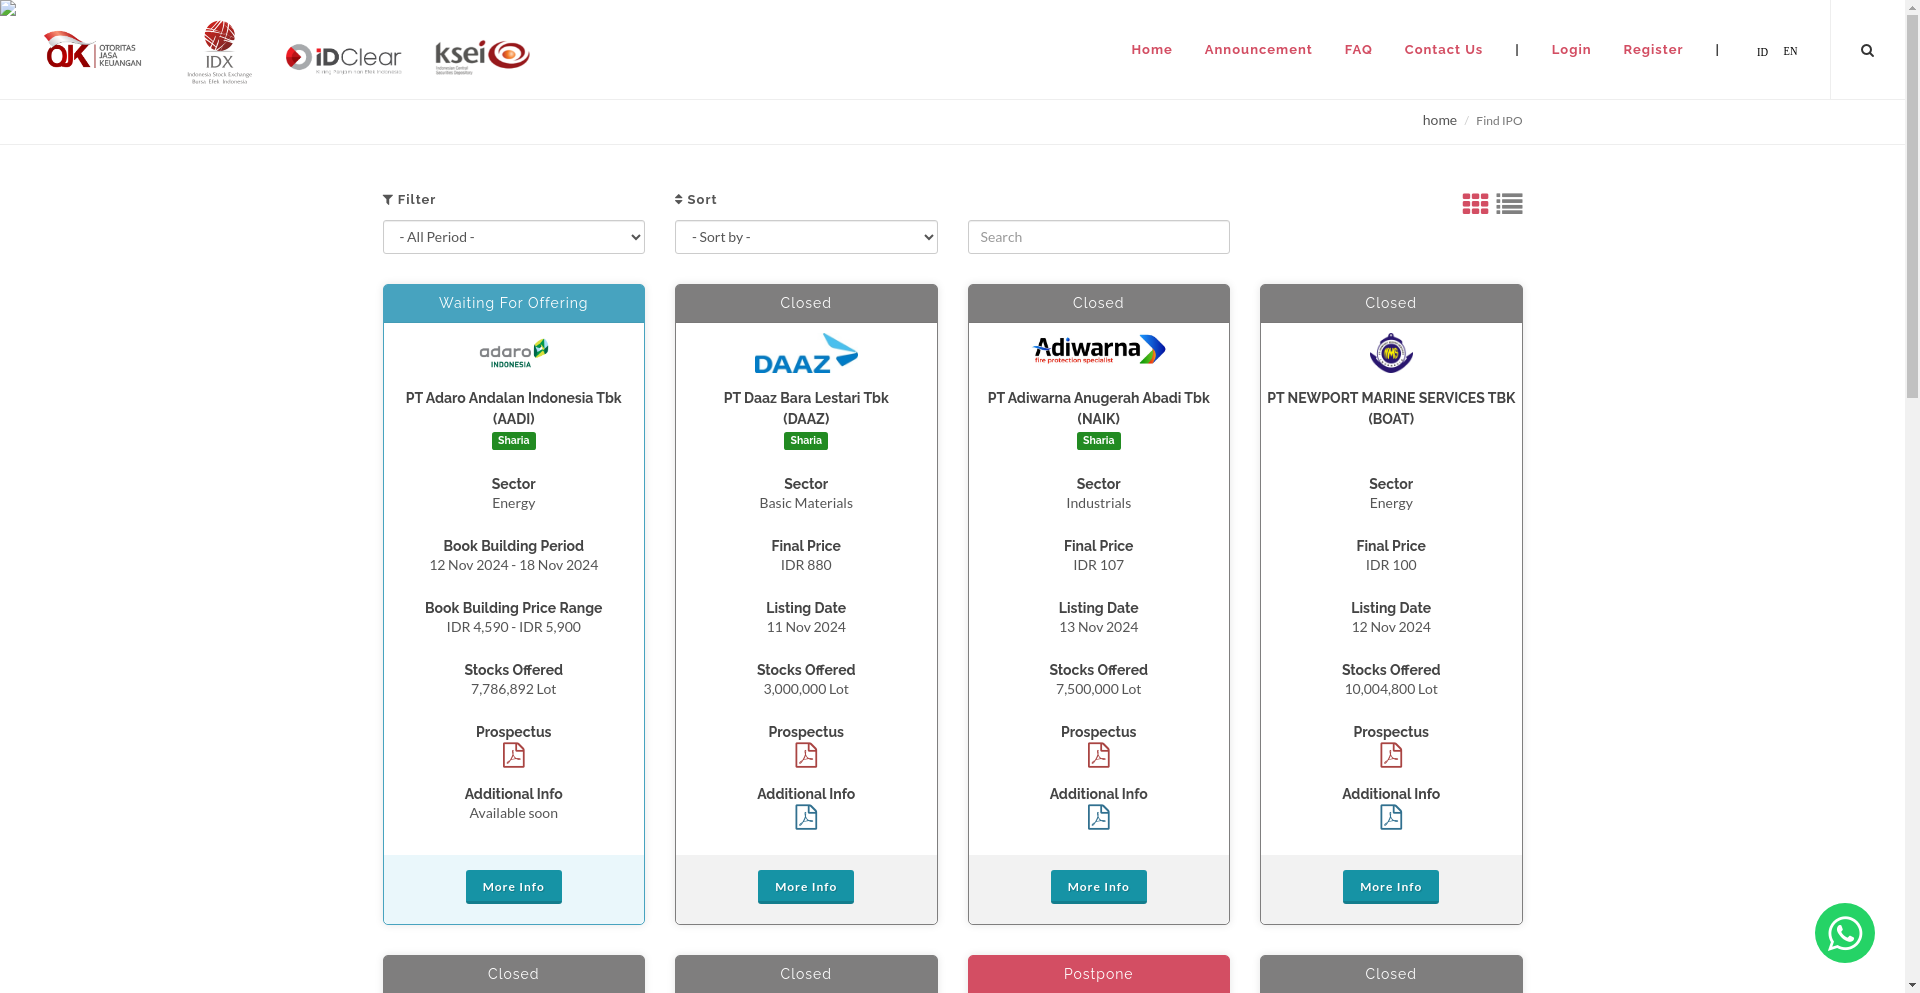

In [6]:
# Bypass Cloudflare
bypass(driver)
time.sleep(5)

# Take a screenshot of the website
Image.open(BytesIO(driver.get_screenshot_as_png()))

# Idea to extract data

Let's first try to access one of the company pages on e-ipo.co.id

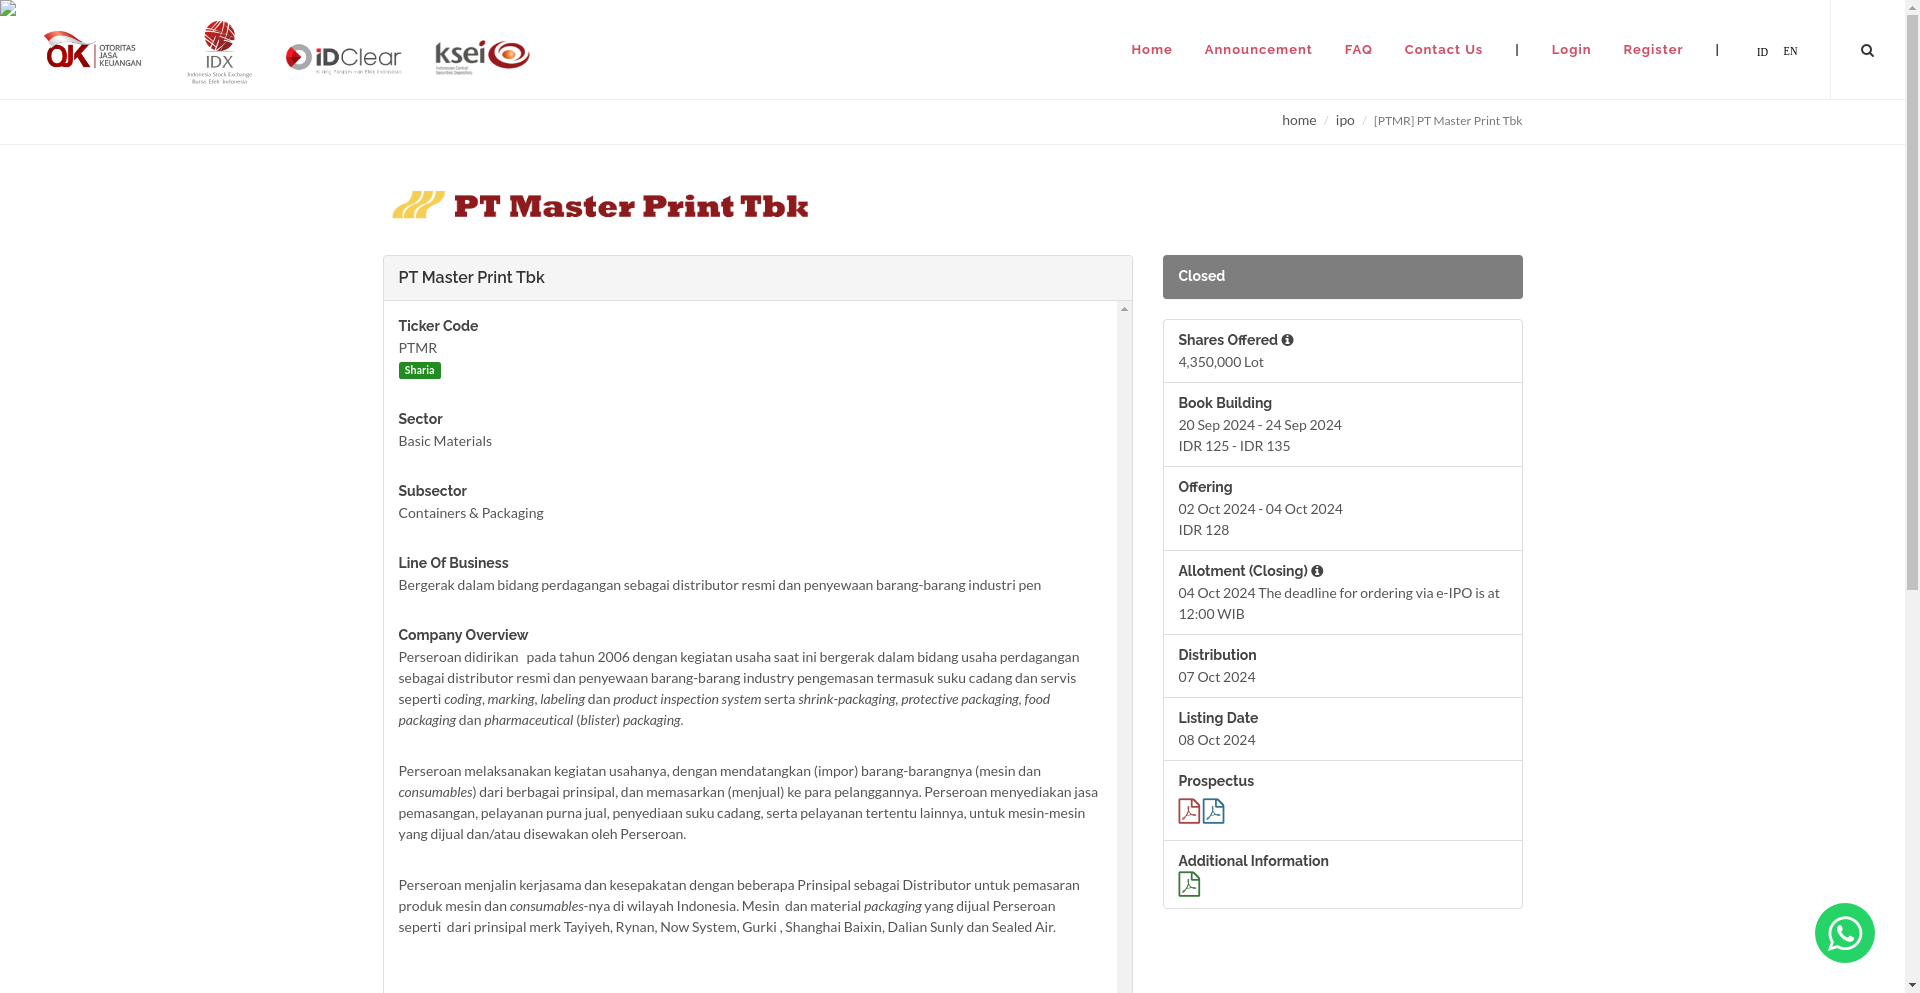

In [7]:
driver.get("https://e-ipo.co.id/en/ipo/314/ptmr-pt-master-print-tbk")
bypass(driver)
time.sleep(5)

# Take a screenshot of the website
Image.open(BytesIO(driver.get_screenshot_as_png()))

By using XPATH, we can extract the text on the page and turn it into a list. (The explanation for this is further explained in the chapter “Breakdown Scraping Code”)

In [8]:
input = driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n'); input

['PT Master Print Tbk',
 'Ticker Code',
 'PTMR',
 'Sharia',
 'Sector',
 'Basic Materials',
 'Subsector',
 'Containers & Packaging',
 'Line Of Business',
 'Bergerak dalam bidang perdagangan sebagai distributor resmi dan penyewaan barang-barang industri pen',
 'Company Overview',
 'Perseroan didirikan   pada tahun 2006 dengan kegiatan usaha saat ini bergerak dalam bidang usaha perdagangan sebagai distributor resmi dan penyewaan barang-barang industry pengemasan termasuk suku cadang dan servis seperti coding, marking, labeling dan product inspection system serta shrink-packaging, protective packaging, food packaging dan pharmaceutical (blister) packaging.',
 'Perseroan melaksanakan kegiatan usahanya, dengan mendatangkan (impor) barang-barangnya (mesin dan consumables) dari berbagai prinsipal, dan memasarkan (menjual) ke para pelanggannya. Perseroan menyediakan jasa pemasangan, pelayanan purna jual, penyediaan suku cadang, serta pelayanan tertentu lainnya, untuk mesin-mesin yang dijual dan

By looking at the pattern of the list, we can select the information we want to retrieve using the index list.

In [9]:
def create_database():
    # Prepare the database structure
    return {key: [] for key in [
        "IPO Status", "Ticker Code", "Company Name", "Sector", "Subsector",
        "Line of Business", "Address", "Website", "Number of shares offered",
        "% of Total Shares", "Participant Admin", "Underwriter(s)",
        "Book Building Period", "Book Building Price", "Offering Period",
        "Final Price (Rp)", "Closing Date", "Distribution Date", "Listing Date",
        "Warrant", "Exercise Price (Warrant) (Rp)"
    ]}

def update_database(database, data):
    """Update the IPO database with new data extracted from the website."""
    newvalue = [None] * 21  # Initialize with None for each data point
    
    # Populate newvalue with extracted data using try-except to handle errors
    try: newvalue[0] = Status_IPO(data)  # IPO Status
    except: pass
    
    try: newvalue[1] = data[2]  # Ticker Code
    except: pass
    
    try: newvalue[2] = data[0]  # Company Name
    except: pass
    
    try: newvalue[3] = data[data.index("Sector") + 1]  # Sector
    except: pass
    
    try:
        newvalue[4] = data[data.index("Subsector") + 1]  # Subsector
        if newvalue[4] == "Line Of Business":
            newvalue[4] = None
    except: pass
    
    try: newvalue[5] = data[data.index("Line Of Business") + 1]  # Line Of Business
    except: pass
    
    try: newvalue[6] = data[data.index("Address") + 1]  # Address
    except: pass
    
    try:
        if "http" in data[data.index("Website") + 1]:
            newvalue[7] = data[data.index("Website") + 1]  # Website
    except: pass
    
    try: newvalue[8] = int(re.sub(r'[^\d]', '', data[data.index("Number of shares offered") + 1]))  # Number of Shares Offered
    except: pass
    
    try: newvalue[9] = float(data[data.index("% of Total Shares") + 1])  # % of Total Shares
    except: pass
    
    try: newvalue[10] = data[data.index("Participant Admin") + 1]  # Participant Admin
    except: pass
    
    try: newvalue[11] = ",".join([item.split(" - ")[0] for item in data[data.index("Underwriter(s)") + 1:data.index(Status_IPO(data))]]) #Underwriter(s)
    except: pass
    
    try:
        if is_string_unique("Book Building", data):  # Book Building Period
            newvalue[12] = data[data.index("Book Building") + 1]
        else:
            newvalue[12] = data[data.index("Book Building", data.index("Book Building") + 1) + 1]
    except: pass
    
    try:
        if is_string_unique("Book Building", data):  # Book Building Price
            if "IDR" in data[data.index("Book Building") + 2]:
                newvalue[13] = data[data.index("Book Building") + 2]
        else:
            if "IDR" in data[data.index("Book Building", data.index("Book Building") + 1) + 2]:
                newvalue[13] = data[data.index("Book Building", data.index("Book Building") + 1) + 2]
    except: pass

    try:
        if is_string_unique("Offering", data):  # Offering Period
            if "-" in data[data.index("Offering") + 1]:
                newvalue[14] = data[data.index("Offering") + 1]
        else:
            if "-" in data[data.index("Offering") + 8]:
                newvalue[14] = data[data.index("Offering") + 8]
    except: pass

    try:
        if is_string_unique("Offering", data):  # Final Price
            if "IDR" in data[data.index("Offering") + 2]:
                newvalue[15] = data[data.index("Offering") + 2]
        else:
            if "IDR" in data[data.index("Offering") + 9]:
                newvalue[15] = data[data.index("Offering") + 9]
    except: pass

    try:
        newvalue[16] = re.findall(r'\d{1,2} \w+ \d{4}', data[data.index("Allotment (Closing)") + 1])[0]  # Allotment Date
    except: pass

    try: newvalue[17] = data[data.index("Distribution") + 1]  # Distribution Date
    except: pass
    
    try: newvalue[18] = data[data.index("Listing Date") + 1]  # Listing Date
    except: pass

    try:
        if ":" in data[data.index("Warant") + 1]:
            newvalue[19] = data[data.index("Warant") + 1]  # Warrant
    except: pass

    try:
        if "IDR" in data[data.index("Exercise Price") + 1]:
            newvalue[20] = data[data.index("Exercise Price") + 1]  # Exercise Price (Warrant)
    except: pass

    # Update the database
    for key, new_value in zip(database.keys(), newvalue):
        database[key].append(new_value)

In [10]:
# Example
test = create_database()
update_database(test, input)
test

{'IPO Status': ['Closed'],
 'Ticker Code': ['PTMR'],
 'Company Name': ['PT Master Print Tbk'],
 'Sector': ['Basic Materials'],
 'Subsector': ['Containers & Packaging'],
 'Line of Business': ['Bergerak dalam bidang perdagangan sebagai distributor resmi dan penyewaan barang-barang industri pen'],
 'Address': [None],
 'Website': ['https://www.masterprint.co.id'],
 'Number of shares offered': [435000000],
 '% of Total Shares': [22.81],
 'Participant Admin': ['RG - PROFINDO SEKURITAS INDONESIA'],
 'Underwriter(s)': ['RG'],
 'Book Building Period': ['20 Sep 2024 - 24 Sep 2024'],
 'Book Building Price': ['IDR 125 - IDR 135'],
 'Offering Period': ['02 Oct 2024 - 04 Oct 2024'],
 'Final Price (Rp)': ['IDR 128'],
 'Closing Date': ['04 Oct 2024'],
 'Distribution Date': ['07 Oct 2024'],
 'Listing Date': ['08 Oct 2024'],
 'Warrant': [None],
 'Exercise Price (Warrant) (Rp)': [None]}

# Scraping Code

In [11]:
def load_dataset():
    """
    Load the existing dataset from a CSV file to optimize data scraping.

    Returns:
        pd.DataFrame: A DataFrame containing the available dataset with unnecessary columns dropped.
    """
    dataset = pd.read_csv("/kaggle/input/e-ipo-realtime-data/e-IPO Data.csv")
    dataset.drop([str(dataset.columns[5])] + list(dataset.columns[7:15]), axis=1, inplace=True)
    return dataset

def adjust_lists(list1, list2):
    """
    Adjust the list of ticker codes to include any missing values.

    Args:
        list1 (list): The original list of ticker codes.
        list2 (list): The list to be adjusted.

    Returns:
        list: The adjusted list with missing values included.
    """
    for item in list1:
        if item not in list2:
            next_item = list1[list1.index(item) + 1] if list1.index(item) + 1 < len(list1) else None
            if next_item:
                list2.insert(list2.index(next_item), item)
    return list2

In [12]:
def scrape_data(refresh_data=False):
    """
    Main function is to scrape IPO data from the e-IPO website. Also, organizing the scraped data to be integrated with existing data.

    Args:
        refresh_data (bool): Flag to determine whether to refresh data or use existing data.
    """
       
    print("Data Scraping Process")

    avail_dataset = load_dataset()
    tickercode_list = []
    
    database = create_database()
    
    max_attempt = 10
    attempt = 0
    timeout = 60
    
    start_i = 1 
    start_j = 1

    while attempt < max_attempt:
        try:
            driver = initialize_driver(stealth_mode=True)  # Initialize the web driver
            driver.get("https://www.e-ipo.co.id/en/ipo/index")
            time.sleep(5)

            bypass(driver) #Bypass cloudflare

            last_page = int(re.search(r'\bpage=(\d+)\b',driver.find_element(By.XPATH,'//*[@id="w0"]/div[2]/div[3]/ul/li[12]/a').get_attribute('href')).group(1))
            time.sleep(3)

            pbar_i = tqdm(range(start_i,last_page+1), desc="Pages")
            for i in pbar_i:
                driver.get("https://www.e-ipo.co.id/en/ipo/index?page=" + str(i) + "&per-page=12")
                WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, '//*[@id="w0"]/div[1]')))

                #Iteration to retrieve information from each company that will conduct an IPO on each page.
                pbar_j = tqdm(range(start_j,13), desc=f"Companies on Page {i}", leave=False)
                for j in pbar_j:
                    #Each company's link will appear in the "link" variable
                    try:
                        WebDriverWait(driver, timeout).until(EC.text_to_be_present_in_element((By.XPATH, '//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[3]/h5'), ''))
                    except:
                        raise NoSuchElementException

                    check_ticker = 0
                    while True:
                        # Extract Ticker Code from Website
                        tickercode = re.findall(r"\((.*?)\)", driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[3]/h5').text)
                        # Make sure Ticker Code is a single string, not a list
                        if isinstance(tickercode, list) and len(tickercode) == 1:
                            tickercode = tickercode[0]
                        # Break the loop if Ticker Code is successfully extracted
                        if tickercode:
                            break

                        # Retry up to 10 times, waiting 3 seconds between each attempt
                        if check_ticker<30:
                            time.sleep(1)
                            check_ticker+=1
                        else:
                            # Run this part, if ticker code not extracted after 10 attempts
                            print(driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[3]/h5').text)
                            raise Exception("Ticker Code Error!")

                    if tickercode:
                        if tickercode not in tickercode_list:
                            tickercode_list.append(tickercode)

                    #Check
                    if not refresh_data:
                        if (tickercode).split('-')[0] in avail_dataset['Ticker Code'].values or tickercode in avail_dataset['Ticker Code'].values:
                            if tickercode in avail_dataset['Ticker Code'].values and str(driver.find_element(By.XPATH, '//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[1]').text) == avail_dataset.loc[avail_dataset[avail_dataset['Ticker Code'] == tickercode].index, 'IPO Status'].values[0]:
                                continue
                            else:
                                if tickercode in avail_dataset['Ticker Code']:
                                    avail_dataset.drop(avail_dataset.loc[avail_dataset['Ticker Code']==tickercode].index, inplace=True)
                                else:
                                    avail_dataset.drop(avail_dataset.loc[avail_dataset['Ticker Code']==(tickercode).split('-')[0]].index, inplace=True)

                    url = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[5]/a').get_attribute('href')

                    #Access company links
                    driver.get(url)
                    WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.ID, "wrapper")))

                    #This script will be used in "WebDriverWait" so that the next code will run when the element with ID "wrapper"
                    #has animationDuration equal to "1.5s" and opacity equal to "1".
                    #Once the conditions are met,the Python code execution will continue.
                    script = """
                        var element = document.getElementById("wrapper");
                        var styles = window.getComputedStyle(element);
                        var animationDuration = styles.animationDuration;
                        var opacity = styles.opacity;
                        return (animationDuration === "1.5s" && opacity === "1");
                    """

                    WebDriverWait(driver, timeout).until(lambda driver: driver.execute_script(script))

                    #The company information is taken from the element in '//*[@id="wrapper"]/section[2]/div/div/div[2]'
                    #which is converted into text. Then the resulting text is converted into a list with a delimiter '\n' (New Line)
                    #and this list will be declared as a new variable called "data".
                    data = driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n')

                    #Update the database with functions that have been created in the preparation step.
                    update_database(database, data)

                    #Exit from the company page (Return to previous page)
                    url = 'https://www.e-ipo.co.id/en/ipo/index?page=' + str(i) + '&per-page=12'
                    driver.get(url)

                    start_j += 1

                start_i +=1
                start_j =1

            # Break out of the loop if scraping is successful
            driver.quit()
            break
    
        except (InvalidSelectorException, NoSuchElementException):
            pbar_i.colour = "#4CAF50"
            pbar_j.colour = "#4CAF50"
            
            pbar_j.close() 
            pbar_i.close()
            break

        except TimeoutException:
            print(f"Error encountered. Switching to another proxy...")
            attempt += 1
            driver.quit()
            continue  # Continue to the next proxy if an error occurs

    if not refresh_data:
        tickercode_list = adjust_lists(list(avail_dataset['Ticker Code']), tickercode_list)

    #Stores the database in the form of a dictionary into a pandas DataFrame
    if database["Ticker Code"]:
        table = pd.DataFrame.from_dict(database)
    else:
        table = None

    '''
    Currently, the data is stored in the DataFrame. For the purpose of further analysis, the data can be modified as follows:
    1. Changing the columns containing date period data such as "Book Building Period" and "Offer Period" into 2 separate columns, namely the opening and closing columns.
    2. Converting the Book Building Price from a range into two separate columns for the opening and closing prices.
    3. Converting the price data into integer form.
    4. Converting the warrant data into the form of warrant per share ratio.
    5. Converting columns containing categorical data into category form and converting columns containing date data into DateTime form
    
    '''

    # Flatten the tickercode_list if it's nested
    tickercode_list = [item for sublist in tickercode_list for item in (sublist if isinstance(sublist, list) else [sublist])]
    tickercode_list = list(dict.fromkeys(tickercode_list))

    if database["Ticker Code"]:
        # Split relevant columns into separate columns
        split_columns = {
            'Book Building Period': ['Book Building Opening', 'Book Building Closing'],
            'Book Building Price': ['Lowest Book Building Price (Rp)', 'Highest Book Building Price (Rp)'],
            'Offering Period': ['Opening of Offering Period', 'Closing of Offering Period']
        }

        for original_col, new_cols in split_columns.items():
            temp_val = table[original_col].str.split(" - ", n=2, expand=True)
            temp_val = temp_val.reindex(columns=range(2), fill_value=None)
            table[new_cols] = temp_val
            table.drop(original_col, axis=1, inplace=True)
            table[new_cols[0]] = table[new_cols[0]].astype('string')
            table[new_cols[1]] = table[new_cols[1]].astype('string')

        # Convert specified price columns to integers
        price_columns = [
            'Lowest Book Building Price (Rp)',
            'Highest Book Building Price (Rp)',
            'Final Price (Rp)',
            'Exercise Price (Warrant) (Rp)'
        ]
        table = convert_to_integer(table, price_columns)

        # Convert the 'Warrant' column to a ratio
        table['Warrant'] = table['Warrant'].apply(warrant_per_share_ratio)
        table.rename(columns={'Warrant': 'Warrant per share ratio'}, inplace=True)

        # Reset index for better handling of rows
        table.reset_index(drop=True, inplace=True)

    else:
        # If the database is empty, fall back to the available dataset
        table = avail_dataset.copy()

    # Convert categorical columns to category type
    category_columns = ["IPO Status", "Sector", "Subsector"]
    for col in category_columns:
        if col in table.columns:
            table[col] = table[col].astype('category')

    # Combine with available dataset if refresh_data is False
    if not refresh_data:
        table = table.reindex(columns=avail_dataset.columns)
        avail_dataset.reset_index(drop=True, inplace=True)
        table = pd.concat([table, avail_dataset], ignore_index=True)

    # Convert date columns to DateTime format
    date_columns = [
        "Book Building Opening",
        "Book Building Closing",
        "Opening of Offering Period",
        "Closing of Offering Period",
        "Closing Date",
        "Distribution Date",
        "Listing Date"
    ]

    for col in date_columns:
        if col in table.columns:
            table[col] = pd.to_datetime(table[col], format='mixed', errors='coerce').dt.date  # Handle errors gracefully
            
    # Remove duplicates and sort by Ticker Code
    table.drop_duplicates(subset=['Ticker Code'], keep='first', inplace=True)
    table['Ticker Code'] = pd.Categorical(table['Ticker Code'], categories=tickercode_list, ordered=True)
    table.sort_values("Ticker Code", inplace=True)
    table.reset_index(drop=True, inplace=True)
            
    if len(table):
        print(f"{len(database['Ticker Code'])} companies data have been collected.")
    else:
        print("There's no recent data. No company data collected.")
    
    return table

# Call the scraping function
table = scrape_data(refresh_data=False)
table.head()

Data Scraping Process


Pages:   0%|          | 0/19 [00:00<?, ?it/s]

Companies on Page 1:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 2:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 3:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 4:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 5:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 6:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 7:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 8:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 9:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 10:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 11:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 12:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 13:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 14:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 15:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 16:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 17:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 18:   0%|          | 0/12 [00:00<?, ?it/s]

Companies on Page 19:   0%|          | 0/12 [00:00<?, ?it/s]

0 companies data have been collected.


,IPO Status,Ticker Code,Company Name,Sector,Subsector,Final Price (Rp),Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Opening,Book Building Closing,Lowest Book Building Price (Rp),Highest Book Building Price (Rp),Opening of Offering Period,Closing of Offering Period,Closing Date,Distribution Date,Listing Date,Warrant per share ratio,Exercise Price (Warrant) (Rp)
0,Waiting For Offering,AADI,PT Adaro Andalan Indonesia Tbk,Energy,Coal Production,NaN,Perusahaan holding dibidang pertambangan batub...,Cyber 2 Tower Lantai 26 Jl. H.R. Rasuna Said B...,https://www.adaroindonesia.com,778689200,10.00,LG - TRIMEGAH SEKURITAS INDONESIA TBK.,LG,2024-11-12,2024-11-18,4590,5900,NaT,NaT,NaT,NaT,NaT,0.0,NaN
1,Closed,DAAZ,PT Daaz Bara Lestari Tbk,Basic Materials,Diversified Metals & Minerals,880.0,"Perdagangan besar logam dan bijih logam, dan a...","Gedung Office 8, SCBD Lot 28, Lantai 21 Unit E...",https://www.daaz-group.com,300000000,15.02,HP - HENAN PUTIHRAI SEKURITAS,"HP,YU",2024-10-11,2024-10-18,835,900,2024-11-01,2024-11-07,2024-11-07,2024-11-08,2024-11-11,0.0,NaN
2,Closed,NAIK,PT Adiwarna Anugerah Abadi Tbk,Industrials,Diversified Industrial Trading,107.0,Bergerak dalam bidang Perdagangan Sistem Prote...,Perkantoran Mutiara Taman Palem No. 53 Cengkar...,https://www.adiwarna.co.id/,750000000,23.08,EP - MNC SEKURITAS,EP,2024-10-22,2024-10-24,100,107,2024-11-07,2024-11-11,2024-11-11,2024-11-12,2024-11-13,0.5,135.0
3,Closed,BOAT,PT NEWPORT MARINE SERVICES TBK,Energy,"Oil, Gas & Coal Equipment & Services",100.0,Sewa dan Menyewa Kapal Untuk Menunjang Kegiata...,Thamrin Residences - Office Park Unit C18 Tham...,https://nms-ina.com/,1000480000,28.57,OD - BRI DANAREKSA SEKURITAS,OD,2024-10-21,2024-10-25,100,120,2024-11-04,2024-11-08,2024-11-08,2024-11-11,2024-11-12,0.0,NaN
4,Closed,PTMR,PT Master Print Tbk,Basic Materials,Containers & Packaging,128.0,Bergerak dalam bidang perdagangan sebagai dist...,NaN,"https://www,masterprint,co,id",435000000,22.81,RG - PROFINDO SEKURITAS INDONESIA,RG,2024-09-20,2024-09-24,125,135,2024-10-02,2024-10-04,2024-10-04,2024-10-07,2024-10-08,0.0,NaN


# Breakdown Scraping Code

In [13]:
backup = table.copy()

Here, I will search for company list elements on the e-ipo website using **XPATH**. I will give an example of how to use XPATH to search for elements.<br>See this code?

    for i in pbar_i:
        driver.get("https://www.e-ipo.co.id/en/ipo/index?page=" + str(i) + "&per-page=12")
        WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, '//*[@id="w0"]/div[1]')))     
In short, this code waits for a specific element specified by the XPath expression to be present on the page. This XPath expression refers to the **company list** element found on each page of the e-IPO website. If the element is found within the given timeout, the code will **continue execution**. If the element is not found, a **timeout exception will be raised**, and the code will print a message before exiting the loop.

To get the XPath code from the list company element, we can use the **Inspect Element** feature in Chrome. The following is an illustration of how I get XPath from the list company element on the e-IPO website, which is

    "//*[@id="w0"]/div[1]".

![](https://imgur.com/H0GhLga.gif)

Once the page is successfully accessed, we can retrieve the information contained in each company on the page. First, we need the link of each company. Where can we get them from? From the *More Info* element of each company. To get the link we will use XPath again. With the same steps, we get the XPath from the *More Info* element, which is

    '//*[@id="w0"]/div[1]/div[1]/div/div/div[5]/a'

![](https://imgur.com/KScrdem.gif)

After getting the XPath of the *More Info* element, we need to retrieve the link from the *href attribute* on the element with the following code

    url = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[5]/a').get_attribute('href')

If you look at the XPath of other companies on the same page, you can see patterns in the XPath. The pattern looks like this

    '//*[@id="w0"]/div[1]/div[1]/div/div/div[5]/a'
    '//*[@id="w0"]/div[1]/div[2]/div/div/div[5]/a'
    '//*[@id="w0"]/div[1]/div[3]/div/div/div[5]/a'
    ...
    '//*[@id="w0"]/div[1]/div[12]/div/div/div[5]/a'

With this pattern, we can iterate to get the information of all companies on each page. It is known that on each page there are 12 companies, so on each page we will iterate to retrieve company information **12 times** from start_j to 13, which is shown in the following code:
    
            pbar_j = tqdm(range(start_j,13), desc=f"Companies on Page {i}", leave=False)
            for j in pbar_j:
                #Each company's link will appear in the "link" variable
                try:
                    WebDriverWait(driver, timeout).until(EC.text_to_be_present_in_element((By.XPATH, '//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[3]/h5'), ''))
                except:
                    raise NoSuchElementException
                
                ........

                url = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j)+']/div/div/div[5]/a').get_attribute('href')

                #Access company links
                driver.get(url)
                WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.ID, "wrapper")))
                
**Notes**: start_j always starts from 1, this variable is defined to be reused when an error occurs in the middle of the data scraping process so that the process can be restarted without repeating from the beginning

On the last page, it is possible that the list of companies is **less than or equal to 12**, so I use the break statement with the tqdm progress bar indicator turning green indicating **no information can be retrieved from the website** because the process has reached the last page and the last company. After we get the company link, we can access and retrieve the information on the company page. Next we will see the following code

        #Access company links
        try:
            
            ....

            driver.get(url)
            WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.ID, "wrapper")))

            #This script will be used in "WebDriverWait" so that the next code will run when the element with ID "wrapper"
            #has animationDuration equal to "1.5s" and opacity equal to "1".
            #Once the conditions are met,the Python code execution will continue.
            script = """
                var element = document.getElementById("wrapper");
                var styles = window.getComputedStyle(element);
                var animationDuration = styles.animationDuration;
                var opacity = styles.opacity;
                return (animationDuration === "1.5s" && opacity === "1");
            """

            WebDriverWait(driver, timeout).until(lambda driver: driver.execute_script(script))

            ....
        
        except (InvalidSelectorException, NoSuchElementException): <- No more information
            pbar_i.colour = "#4CAF50" <- Progress Bar turning green
            pbar_j.colour = "#4CAF50" <- Progress Bar turning green
            
            pbar_j.close() 
            pbar_i.close()
            break

        except TimeoutException:
            print(f"Error encountered. Switching to another proxy...")
            attempt += 1
            driver.quit()
            continue

In the code, we first access the company link. Then there is a script variable which is code in the JavaScript programming language.

This JavaScript takes the element with the ID "wrapper" and gets information related to the **animation style** and **opacity** of the element. Then, it returns true if the **animation duration is 1.5 seconds** and the **opacity is 1**. This is used as a condition to determine if the web page has fully loaded and the animation is complete before continuing the next action.

How do I know if the website loads fully when these conditions are met? We will investigate with the Inspect Element feature while we are loading the company page. Check out the following illustration

![](https://imgur.com/8oCGem3.gif)

Did you see the last update on the web page? The element with **ID "wrapper"** has a variable style with **animation duration of 1.5 seconds** and the **opacity is 1.** Therefore, we will run the next code after these conditions are met, so that the company information can be retrieved.

After that, we can get all the company information on the page by using XPath again. In the same way, we get the XPath of the element containing the company information, which is

    '//*[@id="wrapper"]/section[2]/div/div/div[2]'

![](https://imgur.com/OEspzxN.gif)

To retrieve the information we need, we can split it so that the company information will be in the form of a **list** like this

    data = driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n')
    update_database(database, data)

and we can enter the information into the database with the *update_database* function.

**Notes**: The *update_database* function was created **specifically** for this project. If you want to retrieve information from another website, you must see how the information structure has been retrieved from the website after using the split function and after that you can retrieve information from the list using index like the *update_database* function.

After updating the database, we return to the previous page and retrieve information from the next company until the last company on that page. When the information of the last company on a page has been retrieved, then we access the next page. This step is performed until information from all companies has been retrieved.

# Collect Listing Board Classification

This listing board is taken from the listing activity on the IDX website manually (download the file and then update via Listing Board Dataset).

In [14]:
table = backup.copy()

In [15]:
# Load the Excel file into a DataFrame
board = pd.read_excel("/kaggle/input/listing-board-idx/NewListing-All.xlsx")

# Select relevant columns and rename them for clarity
board.rename(columns={
    "Kode ": "Ticker Code",
    "Papan Pencatatan": "Listing Board"
}, inplace=True)

# Display the first few rows of the processed DataFrame
board.head()

,Ticker Code,Listing Board
0,NAIK,Pengembangan
1,BOAT,Pengembangan
2,DAAZ,Utama
3,PTMR,Pengembangan
4,VERN,Pengembangan


In [16]:
# Merge the 'table' DataFrame with 'board' on the 'Ticker Code' column using a left join
table = pd.merge(table, board, on="Ticker Code", how="left")
    
# Display the first few rows of the merged DataFrame
table.head()

,IPO Status,Ticker Code,Company Name,Sector,Subsector,Final Price (Rp),Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Opening,Book Building Closing,Lowest Book Building Price (Rp),Highest Book Building Price (Rp),Opening of Offering Period,Closing of Offering Period,Closing Date,Distribution Date,Listing Date,Warrant per share ratio,Exercise Price (Warrant) (Rp),Listing Board
0,Waiting For Offering,AADI,PT Adaro Andalan Indonesia Tbk,Energy,Coal Production,NaN,Perusahaan holding dibidang pertambangan batub...,Cyber 2 Tower Lantai 26 Jl. H.R. Rasuna Said B...,https://www.adaroindonesia.com,778689200,10.00,LG - TRIMEGAH SEKURITAS INDONESIA TBK.,LG,2024-11-12,2024-11-18,4590,5900,NaT,NaT,NaT,NaT,NaT,0.0,NaN,NaN
1,Closed,DAAZ,PT Daaz Bara Lestari Tbk,Basic Materials,Diversified Metals & Minerals,880.0,"Perdagangan besar logam dan bijih logam, dan a...","Gedung Office 8, SCBD Lot 28, Lantai 21 Unit E...",https://www.daaz-group.com,300000000,15.02,HP - HENAN PUTIHRAI SEKURITAS,"HP,YU",2024-10-11,2024-10-18,835,900,2024-11-01,2024-11-07,2024-11-07,2024-11-08,2024-11-11,0.0,NaN,Utama
2,Closed,NAIK,PT Adiwarna Anugerah Abadi Tbk,Industrials,Diversified Industrial Trading,107.0,Bergerak dalam bidang Perdagangan Sistem Prote...,Perkantoran Mutiara Taman Palem No. 53 Cengkar...,https://www.adiwarna.co.id/,750000000,23.08,EP - MNC SEKURITAS,EP,2024-10-22,2024-10-24,100,107,2024-11-07,2024-11-11,2024-11-11,2024-11-12,2024-11-13,0.5,135.0,Pengembangan
3,Closed,BOAT,PT NEWPORT MARINE SERVICES TBK,Energy,"Oil, Gas & Coal Equipment & Services",100.0,Sewa dan Menyewa Kapal Untuk Menunjang Kegiata...,Thamrin Residences - Office Park Unit C18 Tham...,https://nms-ina.com/,1000480000,28.57,OD - BRI DANAREKSA SEKURITAS,OD,2024-10-21,2024-10-25,100,120,2024-11-04,2024-11-08,2024-11-08,2024-11-11,2024-11-12,0.0,NaN,Pengembangan
4,Closed,PTMR,PT Master Print Tbk,Basic Materials,Containers & Packaging,128.0,Bergerak dalam bidang perdagangan sebagai dist...,NaN,"https://www,masterprint,co,id",435000000,22.81,RG - PROFINDO SEKURITAS INDONESIA,RG,2024-09-20,2024-09-24,125,135,2024-10-02,2024-10-04,2024-10-04,2024-10-07,2024-10-08,0.0,NaN,Pengembangan


# Collect Stock Returns Data

To fulfill the needs of return analysis on e-IPO stocks, close price data on each stock is taken from **Trading View** using the **tvDataFeed** package which is then processed into return data. Here I create some functions to help with data processing.

**Notes:** The return data taken is the first **7 days return data** because the current e-IPO trend only focuses on the early days of the stock when it starts listing on the stock exchange. Then I also took the return data since the company was listed on the stock exchange until now called **"Return from Listing Date"**.

In [17]:
def get_closing_price(stock_symbol):
    """
    Fetch closing prices for a given stock symbol starting from a specific date.
    
    Parameters:
        stock_symbol (str): The stock symbol to query (e.g., "AAPL").
        pandas_date (pd.Timestamp): The date from which to start fetching closing prices.
        
    Returns:
        list: A list of closing prices (up to 7). Returns [None] if no data is found.
    """
    max_attempts = 10
    for attempt in range(max_attempts):
        # Fetch the closing prices
        close = tv.get_hist(stock_symbol,exchange='IDX',interval=Interval.in_daily,n_bars=1000)['close']
        # Break the loop if fetching was successful
        if not close.empty:
            return close.iloc[:7].tolist()  # Return first 7 closing prices as a list
        else:
            return [None]  # Return None if fetching fails after max attempts

def close_to_return(lst):
    """
    Calculate returns based on closing prices.
    
    Parameters:
        lst (list): A list of closing prices.
        
    Returns:
        list or None: A list of returns, or None if the input list contains None.
    """
    if None in lst:
        return None
    return [(lst[i] - lst[i - 1]) / lst[i - 1] for i in range(1, len(lst))]

In the code below, the data gathering process from Trading View starts and the return data will be inserted into the main dataframe.

In [18]:
tv = TvDatafeed()

keyList_return = ["Return D1",
                  "Return D2",
                  "Return D3",
                  "Return D4",
                  "Return D5",
                  "Return D6",
                  "Return D7"
                 ]

# Initialize the return database
database_return = {key: [] for key in keyList_return}

# Calculate returns for the first week
bar_return = tqdm(range(len(table)), desc="First week Return for Company")
for bar_return, ticker, final, listing in zip(bar_return, table["Ticker Code"], table["Final Price (Rp)"], table["Listing Date"]):
    
    #Fix data (Special Case)
    if ticker == "NETV":
        final = final/2

    return_data = []
    try:
        return_data = close_to_return([int(float(final))] + get_closing_price(ticker))
    except:
        pass
    return_data += [None] * (7 - len(return_data))

    # Update the database with return values
    for key, return_value in zip(database_return.keys(), return_data):
        database_return[key].append(return_value)

#Updating Main DataFrame
table[["Return D1","Return D2","Return D3","Return D4","Return D5","Return D6","Return D7"]] = pd.DataFrame.from_dict(database_return)

# Calculate return from listing date
database_returnListingDate = []
bar_return_listingdate = tqdm(range(len(table)), desc="Return from listing date for Company")
for bar_return, ticker, final, listing in zip(bar_return_listingdate, table["Ticker Code"], table["Final Price (Rp)"], table["Listing Date"]):
    try:
        last_close = tv.get_hist(ticker,exchange='IDX',interval=Interval.in_daily,n_bars=1)['close'][0]
        return_ListingDate = (last_close - final) / final
    except:
        return_ListingDate = np.nan

    database_returnListingDate.append(return_ListingDate)

# Updating Main DataFrame with listing date returns
table["Return from Listing Date"] = pd.DataFrame.from_dict(database_returnListingDate)

First week Return for Company:   0%|          | 0/216 [00:00<?, ?it/s]

Return from listing date for Company:   0%|          | 0/216 [00:00<?, ?it/s]

In [19]:
# Rearranging Columns
table = pd.concat([table.loc[:, 'IPO Status':'Subsector'],
                   table.loc[:, 'Listing Board'],
                   table.loc[:, 'Final Price (Rp)'],
                   table.loc[:, 'Return D1':],
                   table.loc[:, 'Line of Business':'Underwriter(s)'],
                   table.loc[:, 'Book Building Opening':'Closing of Offering Period'],
                   table.loc[:, 'Closing Date':'Exercise Price (Warrant) (Rp)']
                  ], axis=1)

#View the data type of each column in the DataFrame
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   IPO Status                        216 non-null    object 
 1   Ticker Code                       216 non-null    object 
 2   Company Name                      216 non-null    object 
 3   Sector                            216 non-null    object 
 4   Subsector                         214 non-null    object 
 5   Listing Board                     207 non-null    object 
 6   Final Price (Rp)                  207 non-null    float64
 7   Return D1                         207 non-null    float64
 8   Return D2                         207 non-null    float64
 9   Return D3                         207 non-null    float64
 10  Return D4                         207 non-null    float64
 11  Return D5                         207 non-null    float64
 12  Return D

In [20]:
# Display DataFrame
table

,IPO Status,Ticker Code,Company Name,Sector,Subsector,Listing Board,Final Price (Rp),Return D1,Return D2,Return D3,Return D4,Return D5,Return D6,Return D7,Return from Listing Date,Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Opening,Book Building Closing,Lowest Book Building Price (Rp),Highest Book Building Price (Rp),Opening of Offering Period,Closing of Offering Period,Closing Date,Distribution Date,Listing Date,Warrant per share ratio,Exercise Price (Warrant) (Rp)
0,Waiting For Offering,AADI,PT Adaro Andalan Indonesia Tbk,Energy,Coal Production,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Perusahaan holding dibidang pertambangan batub...,Cyber 2 Tower Lantai 26 Jl. H.R. Rasuna Said B...,https://www.adaroindonesia.com,778689200,10.00,LG - TRIMEGAH SEKURITAS INDONESIA TBK.,LG,2024-11-12,2024-11-18,4590,5900,NaT,NaT,NaT,NaT,NaT,0.0,NaN
1,Closed,DAAZ,PT Daaz Bara Lestari Tbk,Basic Materials,Diversified Metals & Minerals,Utama,880.0,0.2500,0.2500,0.2473,0.2478,0.2477,0.2472,0.2462,3.7159,"Perdagangan besar logam dan bijih logam, dan a...","Gedung Office 8, SCBD Lot 28, Lantai 21 Unit E...",https://www.daaz-group.com,300000000,15.02,HP - HENAN PUTIHRAI SEKURITAS,"HP,YU",2024-10-11,2024-10-18,835,900,2024-11-01,2024-11-07,2024-11-07,2024-11-08,2024-11-11,0.0,NaN
2,Closed,NAIK,PT Adiwarna Anugerah Abadi Tbk,Industrials,Diversified Industrial Trading,Pengembangan,107.0,0.3458,0.3472,0.3402,0.0000,0.0154,-0.1591,NaN,1.0748,Bergerak dalam bidang Perdagangan Sistem Prote...,Perkantoran Mutiara Taman Palem No. 53 Cengkar...,https://www.adiwarna.co.id/,750000000,23.08,EP - MNC SEKURITAS,EP,2024-10-22,2024-10-24,100,107,2024-11-07,2024-11-11,2024-11-11,2024-11-12,2024-11-13,0.5,135.0
3,Closed,BOAT,PT NEWPORT MARINE SERVICES TBK,Energy,"Oil, Gas & Coal Equipment & Services",Pengembangan,100.0,0.3500,0.0667,-0.0903,0.0534,-0.0362,0.1579,0.3377,1.0600,Sewa dan Menyewa Kapal Untuk Menunjang Kegiata...,Thamrin Residences - Office Park Unit C18 Tham...,https://nms-ina.com/,1000480000,28.57,OD - BRI DANAREKSA SEKURITAS,OD,2024-10-21,2024-10-25,100,120,2024-11-04,2024-11-08,2024-11-08,2024-11-11,2024-11-12,0.0,NaN
4,Closed,PTMR,PT Master Print Tbk,Basic Materials,Containers & Packaging,Pengembangan,128.0,0.0703,-0.0365,0.0000,-0.0076,-0.0076,0.0000,0.0000,0.0078,Bergerak dalam bidang perdagangan sebagai dist...,NaN,"https://www,masterprint,co,id",435000000,22.81,RG - PROFINDO SEKURITAS INDONESIA,RG,2024-09-20,2024-09-24,125,135,2024-10-02,2024-10-04,2024-10-04,2024-10-07,2024-10-08,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Closed,BMHS,PT Bundamedik Tbk,Healthcare,Healthcare Providers,Utama,340.0,0.2471,0.2500,0.2453,0.2500,0.2424,-0.0439,-0.0051,-0.2353,Bergerak di bidang aktivitas rumah sakit swast...,"Jl, Teuku Cik Ditiro No, 28, Menteng Jakarta 1...","https://www,bmhs,co,id",620000000,7.26,KI - CIPTADANA SEKURITAS ASIA,KI,2021-06-17,2021-06-22,300,350,2021-06-30,2021-07-02,2021-07-02,2021-07-05,2021-07-06,0.0,NaN
212,Closed,MASB,PT Bank Multiarta Sentosa Tbk,Financials,Banks,Pengembangan,3360.0,0.2500,-0.0690,-0.0691,-0.0687,0.0177,-0.0058,-0.0029,-0.0030,Bank,NaN,"https://www,bankmas,co,id",186176500,15.00,SQ - BCA SEKURITAS,SQ,2021-06-07,2021-06-15,3000,4000,2021-06-24,2021-06-28,2021-06-28,2021-06-29,2021-06-30,1.0,3500.0
213,Closed,ARCI,PT Archi Indonesia Tbk,Basic Materials,Gold,Pengembangan,750.0,0.0067,-0.0265,0.0204,0.0000,0.0000,-0.0200,-0.0204,-0.6427,Perusahaan holding di bidang pertambangan mine...,"Menara Rajawali, Lantai 19, Jl, DR Ide Anak Ag...","https://www,archiindonesia,com",3725250000,15.00,AI - UOB KAY HIAN SEKURITAS,"AI,CC,C4,CS,NI",2021-05-31,2021-06-09,750,800,2021-06-22,2021-06-24,2021-06-24,2021-06-25,2021-06-28,0.0,NaN
214,Closed,UNIQ,PT Ulima Nitra Tbk,Energy,"Oil, Gas & Coal Equipment & Services",Utama,118.0,0.3475,0.2264,-0.0667,-0.0659,-

# Warrant Data Frame

Sometimes some e-IPOs offer warrants alongside their shares to attract investors. Warrants are a bonus received by investors after purchasing shares. This warrant dataset is intended to see the High Price of warrants on the first day of e-IPO so that we can take profit as optimally as possible.

In [21]:
tv = TvDatafeed()

warrant_key = ["Open",
                "High",
                "Low",
                "Close",
               "Ticker Code"
               ]

warrant_database = {key: [] for key in warrant_key}

for index,row in tqdm(table[['Ticker Code','Warrant per share ratio']].iterrows(), total=table.shape[0], desc="Warrant Data for each company"):
    if "-C1" in row[0]:
        continue
    if row[1]!=0:
        try:
            data_w = tv.get_hist(symbol=row[0]+'.W',exchange='IDX',interval=Interval.in_daily,n_bars=1000).iloc[0].iloc[1:5]
            data_w["Ticker Code"]=row[0]
            for key, value in zip(warrant_database.keys(),data_w):
                warrant_database[key].append(value)
        except:
            for key, value in zip(warrant_database.keys(), ["-","-","-","-",row[0]]):
                warrant_database[key].append(value)

warrant_df = None
warrant_df = pd.merge(table[['Ticker Code',
                               'Participant Admin',
                               'Underwriter(s)',
                               'Listing Board',
                               'Final Price (Rp)',
                               'Warrant per share ratio',
                               'Exercise Price (Warrant) (Rp)']],
                        pd.DataFrame.from_dict(warrant_database),
                      on="Ticker Code")

warrant_df['Ticker Code'] = warrant_df['Ticker Code'].apply(lambda x: x+"-W"); warrant_df

Warrant Data for each company:   0%|          | 0/216 [00:00<?, ?it/s]

,Ticker Code,Participant Admin,Underwriter(s),Listing Board,Final Price (Rp),Warrant per share ratio,Exercise Price (Warrant) (Rp),Open,High,Low,Close
0,NAIK-W,EP - MNC SEKURITAS,EP,Pengembangan,107.0,0.5000,135.0,28.0,62.0,23.0,48.0
1,VERN-W,AI - UOB KAY HIAN SEKURITAS,AI,Pengembangan,195.0,0.5000,216.0,33.0,50.0,11.0,12.0
2,ISEA-W,CP - KB VALBURY SEKURITAS,CP,Pengembangan,250.0,0.5000,226.0,23.0,123.0,20.0,60.0
3,PART-W,EP - MNC SEKURITAS,"EP,AO,CP",Pengembangan,105.0,1.0000,110.0,20.0,22.0,12.0,12.0
4,BATR-W,HD - KGI SEKURITAS INDONESIA,HD,Pengembangan,110.0,1.0000,300.0,20.0,27.0,5.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...
85,SBMA-W,HD - KGI SEKURITAS INDONESIA,HD,Pengembangan,180.0,0.1667,230.0,-,-,-,-
86,OILS-W,BQ - KOREA INVESTMENT AND SEKURITAS INDONESIA,BQ,Pengembangan,270.0,0.2500,320.0,-,-,-,-
87,GPSO-W,SF - SURYA FAJAR SEKURITAS,"SF,XA",Pengembangan,180.0,1.0000,250.0,-,-,-,-
88,UVCR-W,SF - SURYA FAJAR SEKURITAS,"SF,XA,YP",Pengembangan,100.0,0.5000,350.0,-,-,-,-


# Closing

The data has been collected and is ready to be exported into CSV and updated to google spreadsheet as well.

In [22]:
'''
CAUTION!
This section of code is designed for performing a manual update of financial data related to an IPO (Initial Public Offering) process. 
It allows users to update the existing dataset without relying on automated web scraping.
'''
manual_refresh = False


# Define a date parsing function to convert date strings into datetime objects
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

# Define a list of columns in the DataFrame that contain date data
listdate_column = [
    "Book Building Opening",
    "Book Building Closing",
    "Opening of Offering Period",
    "Closing of Offering Period",
    "Closing Date",
    "Distribution Date",
    "Listing Date"
]

# Check if a manual refresh is required
if manual_refresh:
    # Load the main data from a CSV file for manual updates
    table = pd.read_csv(
        '/kaggle/input/manual-update-e-ipo/e-IPO Data.csv',
        sep=';',  # Specify the separator used in the CSV file
        parse_dates=listdate_column,  # Automatically parse specified columns as dates
        decimal=",",  # Specify the decimal character used in the CSV
        dayfirst=True
    )
    
    # Load the warrant price data from another CSV file for manual updates
    warrant_df = pd.read_csv(
        '/kaggle/input/manual-update-e-ipo/Warrant - Price D1.csv',
        sep=";",
        decimal=","
    )

In [23]:
# Save DataFrame to CSV
table.to_csv("e-IPO Data.csv", date_format='%Y-%m-%d', index=False)
warrant_df.to_csv("Warrant - Price D1.csv", date_format='%Y-%m-%d', index=False)

# Authorize Google Sheets API
credential = ServiceAccountCredentials.from_json_keyfile_dict(
    json.loads(UserSecretsClient().get_secret("mycredential"))
)
gc = gspread.authorize(credential)

# Open Google Spreadsheet and save DataFrames
spreadsheet = gc.open_by_url(UserSecretsClient().get_secret("spreadsheet_link"))
set_with_dataframe(spreadsheet.worksheet('Dataset'), table)
set_with_dataframe(spreadsheet.worksheet('Data Waran D1'), warrant_df)

# Save 'table' DataFrame to another Google Spreadsheet
spreadsheet = gc.open_by_url(UserSecretsClient().get_secret("spreadsheet_link_USERS"))
set_with_dataframe(spreadsheet.worksheet('Dataset'), table)

I am open to any feedback and suggestions on this notebook, so that I can improve and make better projects. Thank you.

# Dataset

The data collected from this web scraping project will be available in the following kaggle dataset<br>
https://www.kaggle.com/datasets/fahmirk/e-ipo-realtime-data

Data is updated daily using the schedule run feature.